Raveel Tejani, Sam Young

# Lab 14: Flavours of Boosting and Feature Importance

In this notebook, we build a photometric redshift estimator using various boosting methods: AdaBoost and various flavors of Gradient Boosted Trees (GBM, HistGBM, and XGBoost). We also look at using RandomizedSearchCV in order to improve our exploration of parameter space.

Our goal is to estimate photometric redshifts starting from observations of galaxy magnitudes in six different photometric bands (u, g, r, i, z, y). 

License: [BSD-3-clause](https://opensource.org/license/bsd-3-clause/)

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
from joblib import parallel_backend

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 100)

font = {'size'   : 16}
matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
#matplotlib.rcParams.update({'figure.autolayout': True})
matplotlib.rcParams['figure.dpi'] = 100

In [2]:
from sklearn import metrics
from sklearn.model_selection import cross_validate, cross_val_score, KFold, cross_val_predict, GridSearchCV,RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, RandomForestRegressor

# read in pre-processed data from Lab 13
sel_features = pd.read_csv('sel_features.csv', sep = '\t')
sel_target = pd.read_csv('sel_target.csv')
sel_features = sel_features.to_numpy()
sel_target = sel_target.to_numpy().T[0]

## Step 1: AdaBoost again 

In Lab 13, we showed that for AdaBoostRegressor, stacking learners that are too weak doesn't help. Let's do a more thorough optimization of hyperparameters for AdaBoost. 

First, look at the model hyperparameters using model.get_params. As estimator use DecisionTreeRegressor(). Set up a **GridSearchCV** and find the best model within the suggested parameters.  

'estimator__max_depth':[6,10,None], 'loss':['linear','square'], 'n_estimators':[20,50,100], 'learning_rate': [0.3,0.5,1.0]

You can use 3-fold CV. Use n_jobs=-1 to request all resources. If the run time turns out to be too long on your machine, use **RandomizedSearchCV** with n_iter=50 or 100 instead. Normally we would only use the randomized search in higher dimensional parameter space, but it should be sufficient here. You can increase n_inter according to your patience threshold!

What are the test scores, optimal parameters and outlier fraction of the winning model? 

In [3]:
model = AdaBoostRegressor(estimator = DecisionTreeRegressor())
model.get_params()

{'base_estimator': 'deprecated',
 'estimator__ccp_alpha': 0.0,
 'estimator__criterion': 'squared_error',
 'estimator__max_depth': None,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__random_state': None,
 'estimator__splitter': 'best',
 'estimator': DecisionTreeRegressor(),
 'learning_rate': 1.0,
 'loss': 'linear',
 'n_estimators': 50,
 'random_state': None}

In [4]:
parameters = {'estimator__max_depth':[6,10,None], 'loss':['linear','square'], 'n_estimators':[20,50,100],
              'learning_rate': [0.3,0.5,1.0]}

In [5]:
gmodel = GridSearchCV(model, parameters, cv = KFold(n_splits=3, shuffle=True), \
                     verbose = 2, n_jobs = -1)
gmodel.fit(sel_features, sel_target)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
             estimator=AdaBoostRegressor(estimator=DecisionTreeRegressor()),
             n_jobs=-1,
             param_grid={'estimator__max_depth': [6, 10, None],
                         'learning_rate': [0.3, 0.5, 1.0],
                         'loss': ['linear', 'square'],
                         'n_estimators': [20, 50, 100]},
             verbose=2)

In [6]:
test_scores = gmodel.cv_results_['mean_test_score']
print('Test Scores {}:'.format(test_scores))
print('')
print('Best params, best score:', "{:.4f}".format(gmodel.best_score_), gmodel.best_params_)

ypred = gmodel.predict(sel_features)
outlier_frac = len(sel_target[np.abs(sel_target - ypred)/(1 + ypred) > 0.15])/len(sel_target)
print('')
print('outlier fraction: {}'.format(outlier_frac))

Test Scores [0.57292836 0.54202351 0.52609128 0.51482804 0.48623412 0.50167849
 0.55366845 0.53030844 0.49624596 0.4749736  0.49909538 0.51408945
 0.50021134 0.50444396 0.48903264 0.41486604 0.49923259 0.51349834
 0.70266578 0.71894122 0.71749862 0.68157709 0.70374851 0.69238192
 0.70440807 0.70442416 0.71738098 0.68533389 0.69759786 0.70313938
 0.69391011 0.71271238 0.71703081 0.6486128  0.68158508 0.69046057
 0.71805319 0.7251787  0.73663042 0.70665512 0.731688   0.73727721
 0.70386034 0.73304215 0.73385608 0.70796901 0.7227502  0.73584299
 0.72652008 0.7378555  0.74527715 0.72396042 0.70910584 0.72468184]:

Best params, best score: 0.7453 {'estimator__max_depth': None, 'learning_rate': 1.0, 'loss': 'linear', 'n_estimators': 100}

outlier fraction: 0.0


## Step 2: Gradient Boosted Trees

Let's repeat the analysis above for three GB variants:
1. GradientBoostingRegressor

Suggested parameters: 'max_depth':[6,10,None], 'loss':['squared_error','absolute_error'], 'n_estimators':[20,50,100], 'learning_rate': [0.1,0.3,0.5]

2. HistGradientBoostingRegressor

HistGradientBoostingRegressor (inspired by LightGBM) works by binning the features into integer-valued bins (the default value is 256, but this parameter can be adjusted; note however that 256 is the maximum!), which greatly reduces the number of splitting points to consider, and results in a vast reduction of computation time, especially for large data sets.

Suggested paramters: 'max_depth':[6,10,None], 'loss':['squared_error','absolute_error'], 'max_iter':[20,50,100], 'learning_rate': [0.1,0.3,0.5]

3. XGBRegressor. The latter requires installation of the python package xgboost. 

XGBoost stands for “Extreme Gradient Boosting”. It is sometimes known as "regularized" GBM, as it has a default regularization term on the weights of the ensemble, and is more robust to overfitting. It has more flexibility in defining weak learners, as well as the objective (loss) function (note that this doesn't apply to the base estimators, e.g. how splits in trees are chosen, but on the loss that is used to compute pseudoresiduals and gradients).

Suggested parameters: 'max_depth':[6,10,None], 'n_estimators':[50,100,200], 'learning_rate': [0.1, 0.3,0.5], 'objective':['reg:squarederror','reg:squaredlogerror']

What are the test scores, optimal parameters and outlier fraction for the winning models in each case? 

In [7]:
model = GradientBoostingRegressor()

parameters = {'max_depth':[6,10,None], 'loss':['squared_error','absolute_error'],
              'n_estimators':[20,50,100], 'learning_rate': [0.1,0.3,0.5]}

gmodel = GridSearchCV(model, parameters, cv = KFold(n_splits=3, shuffle=True), \
                     verbose = 0, n_jobs = -1)

gmodel.fit(sel_features, sel_target)

test_scores = gmodel.cv_results_['mean_test_score']
print('Test Scores {}:'.format(test_scores))
print('')
print('Best params, best score:', "{:.4f}".format(gmodel.best_score_), gmodel.best_params_)

ypred = gmodel.predict(sel_features)
outlier_frac = len(sel_target[np.abs(sel_target - ypred)/(1 + ypred) > 0.15])/len(sel_target)
print('')
print('outlier fraction: {}'.format(outlier_frac))

Test Scores [0.66122894 0.71969466 0.73326195 0.71957351 0.73950154 0.73781309
 0.64660514 0.63551597 0.63527989 0.62769862 0.69252411 0.7190998
 0.69737628 0.72762618 0.72677098 0.6981585  0.73810647 0.74533961
 0.70491608 0.7151348  0.71731806 0.72834613 0.72381461 0.72745961
 0.63141263 0.62907295 0.63087061 0.67542177 0.69062369 0.69666233
 0.70858608 0.7033707  0.71761115 0.70694696 0.71698527 0.71814939
 0.67364903 0.67953294 0.67813024 0.69113646 0.69400771 0.70348886
 0.62518785 0.62110503 0.6362241  0.68021372 0.65516347 0.6753762
 0.66612724 0.67703178 0.68379489 0.67866316 0.66570497 0.67001082]:

Best params, best score: 0.7453 {'learning_rate': 0.1, 'loss': 'absolute_error', 'max_depth': None, 'n_estimators': 100}

outlier fraction: 0.00015855398763278897


In [8]:
model = HistGradientBoostingRegressor()

parameters = {'max_depth':[6,10,None], 'loss':['squared_error','absolute_error'],
              'max_iter':[20,50,100], 'learning_rate': [0.1,0.3,0.5]}

gmodel = GridSearchCV(model, parameters, cv = KFold(n_splits=3, shuffle=True), \
                     verbose = 0, n_jobs = -1)

gmodel.fit(sel_features, sel_target)

test_scores = gmodel.cv_results_['mean_test_score']
print('Test Scores {}:'.format(test_scores))
print('')
print('Best params, best score:', "{:.4f}".format(gmodel.best_score_), gmodel.best_params_)

ypred = gmodel.predict(sel_features)
outlier_frac = len(sel_target[np.abs(sel_target - ypred)/(1 + ypred) > 0.15])/len(sel_target)
print('')
print('outlier fraction: {}'.format(outlier_frac))

Test Scores [0.62507599 0.67887196 0.69276871 0.63478647 0.69018571 0.70247674
 0.63540385 0.69527997 0.70730317 0.60856581 0.67379982 0.69249495
 0.61523272 0.67870989 0.69806109 0.61513972 0.68042771 0.69911065
 0.67016419 0.68452945 0.68980375 0.6830631  0.69510388 0.69537187
 0.68296308 0.69641794 0.69704547 0.66978176 0.68944384 0.69760085
 0.67465099 0.69164718 0.70178516 0.67863682 0.69530929 0.70278415
 0.65294324 0.66261946 0.66223213 0.66469242 0.67021612 0.66961839
 0.67620255 0.67843993 0.67606804 0.66617106 0.68147076 0.68872879
 0.67630449 0.68712288 0.69381141 0.67557471 0.68885698 0.69371938]:

Best params, best score: 0.7073 {'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': None, 'max_iter': 100}

outlier fraction: 0.03440621531631521


In [9]:
# check xgboost version
import xgboost

model = xgboost.XGBRegressor()

parameters = {'max_depth':[6,10,None], 'n_estimators':[50,100,200], 'learning_rate': [0.1, 0.3,0.5],
              'objective':['reg:squarederror','reg:squaredlogerror']}

gmodel = GridSearchCV(model, parameters, cv = KFold(n_splits=3, shuffle=True), \
                     verbose = 0, n_jobs = -1)

gmodel.fit(sel_features, sel_target)

test_scores = gmodel.cv_results_['mean_test_score']
print('Test Scores {}:'.format(test_scores))
print('')
print('Best params, best score:', "{:.4f}".format(gmodel.best_score_), gmodel.best_params_)

ypred = gmodel.predict(sel_features)
outlier_frac = len(sel_target[np.abs(sel_target - ypred)/(1 + ypred) > 0.15])/len(sel_target)
print('')
print('outlier fraction: {}'.format(outlier_frac))

Test Scores [0.70345669 0.69014057 0.71966322 0.71123492 0.72731553 0.72178027
 0.72746745 0.71901125 0.72847574 0.72583633 0.7293738  0.72645657
 0.70345669 0.69014057 0.71966322 0.71123492 0.72731553 0.72178027
 0.70444786 0.70880693 0.70604996 0.71629071 0.70869575 0.72201015
 0.71241022 0.71901009 0.71242901 0.72232175 0.71248662 0.72347065
 0.70444786 0.70880693 0.70604996 0.71629071 0.70869575 0.72201015
 0.70189445 0.71035728 0.70318393 0.7172628  0.70328621 0.7195735
 0.68895365 0.7083305  0.68873702 0.71018822 0.68873301 0.71040866
 0.70189445 0.71035728 0.70318393 0.7172628  0.70328621 0.7195735 ]:

Best params, best score: 0.7294 {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'objective': 'reg:squarederror'}

outlier fraction: 0.0


## Step 3: Feature importance

Although one of the main goals of ML is to be able to make predictions as accurate as possible, it is equally desirable to gain insight into why the machine makes certain decisions. To this end, we would like to be able to identify those features that are most important in the classification or regression process. This is sometimes called "interpretable machine learning".

Our new ensemble methods all have a property .feature_importances_. What does this property give you in the case of a random forest?

For the RandomForestRegressor, the AdaBoostRegressor, and the XGBRegressor, find those importances, rank them in order of importance and make a bar chart for each regressor that plots the importances of the six features in our redshift dataset, starting with the most important one. To this end, just fit the models to the full dataset, no split test/train needed. You can use the optimized parameters you found above. Do you get the same answer from all three regressors?

**the top two features on each are the same, then we see some difference for XGboost**. 

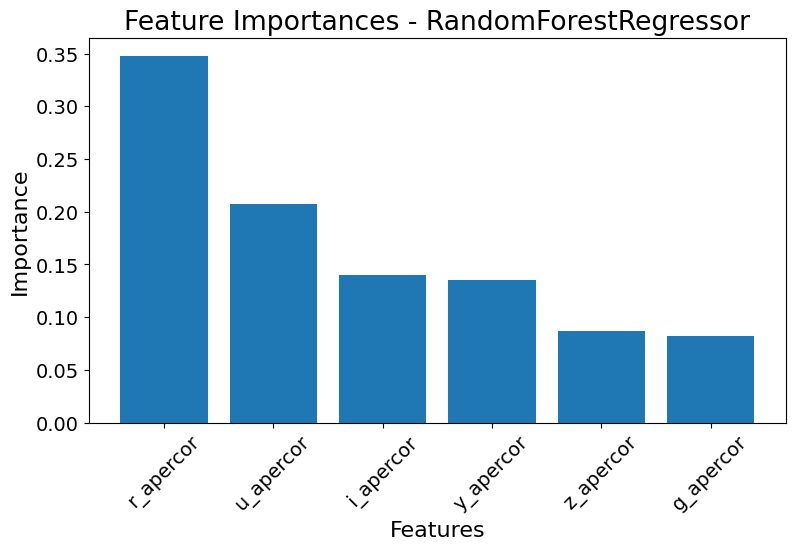

In [10]:
#best_params = {'max_depth': None, 'n_estimators': 100}
model = RandomForestRegressor()
model.fit(sel_features, sel_target)

feature_importances = model.feature_importances_

sel_features = pd.read_csv('sel_features.csv', sep = '\t')
sort_index = np.argsort(feature_importances)[::-1]
feature_importances = feature_importances[sort_index]
feature_names = sel_features.columns[sort_index]


plt.figure(figsize=(9, 5))
plt.bar(feature_names, feature_importances)
plt.title('Feature Importances - RandomForestRegressor')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.show()

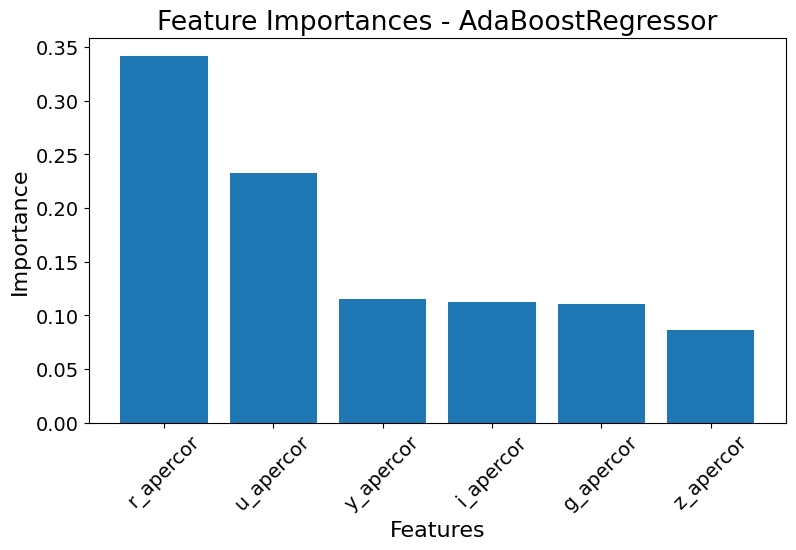

In [11]:
best_params= {'learning_rate': 0.3, 'loss': 'linear', 'n_estimators': 50}

model = AdaBoostRegressor(estimator = DecisionTreeRegressor(max_depth = None), **best_params)
model.fit(sel_features, sel_target)

feature_importances = model.feature_importances_

sel_features = pd.read_csv('sel_features.csv', sep = '\t')
sort_index = np.argsort(feature_importances)[::-1]
feature_importances = feature_importances[sort_index]
feature_names = sel_features.columns[sort_index]


plt.figure(figsize=(9, 5))
plt.bar(feature_names, feature_importances)
plt.title('Feature Importances - AdaBoostRegressor')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.show()

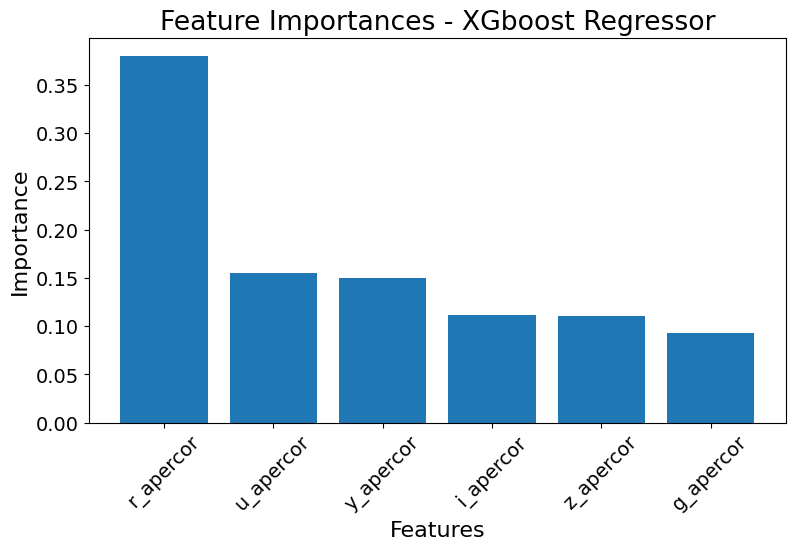

In [12]:
best_params= {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'objective': 'reg:squaredlogerror'}

model = xgboost.XGBRegressor(**best_params)
model.fit(sel_features, sel_target)

feature_importances = model.feature_importances_

sel_features = pd.read_csv('sel_features.csv', sep = '\t')
sort_index = np.argsort(feature_importances)[::-1]
feature_importances = feature_importances[sort_index]
feature_names = sel_features.columns[sort_index]


plt.figure(figsize=(9, 5))
plt.bar(feature_names, feature_importances)
plt.title('Feature Importances - XGboost Regressor')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.show()

## Step 4: Correlations among features

It is very common for the features to be correlated amonst each other. This can complicate the interpretation of feature importance, since two highly correlated features might receive equal weight. Correlated features also introduce reduncancy in the overall model so it is desirable to develop strategies to remove them.

1. Determine the cross-correlations between the six features in our dataset. There are several options to do this, in pandas we could just use the .corr() method. Find the pair of features that is most correlated.

**z_apercor and i_apercor are the most correlated**

In [13]:
sel_features.corr()

,u_apercor,g_apercor,r_apercor,i_apercor,z_apercor,y_apercor
u_apercor,1.000000,0.915305,0.753184,0.631486,0.575135,0.518988
g_apercor,0.915305,1.000000,0.942970,0.857824,0.808478,0.756417
r_apercor,0.753184,0.942970,1.000000,0.967325,0.933308,0.891326
i_apercor,0.631486,0.857824,0.967325,1.000000,0.988283,0.955787
z_apercor,0.575135,0.808478,0.933308,0.988283,1.000000,0.974205
y_apercor,0.518988,0.756417,0.891326,0.955787,0.974205,1.000000


2. From these two features, which one is less correlated with the target variable? Eliminate that feature and redo the feature ranking for the three regressors with this new model that now only has 5 features. Also compute a cross-validated score for these smaller models, are they worse than for the full model? What do you think? 

**z_apercor is less correlated and is removed**

**scores are about the same, the smaller models did not show significant improvement**

In [14]:
sel_target = pd.read_csv('sel_target.csv')
test = pd.concat([sel_features['z_apercor'], sel_target['zhelio']], axis=1)
test.corr()

,z_apercor,zhelio
z_apercor,1.000000,0.299554
zhelio,0.299554,1.000000


In [15]:
test = pd.concat([sel_features['i_apercor'], sel_target['zhelio']], axis=1)
test.corr()

,i_apercor,zhelio
i_apercor,1.000000,0.384855
zhelio,0.384855,1.000000


In [16]:
sel_features = sel_features.drop(['z_apercor'], axis=1)

sel_features

,u_apercor,g_apercor,r_apercor,i_apercor,y_apercor
0,24.2444,23.9796,23.5221,22.9110,22.3291
1,24.4891,23.9162,22.9237,21.8738,21.2514
2,24.8740,22.9739,21.4659,20.7884,20.4137
3,24.5290,24.3386,23.8912,23.2061,23.1124
4,23.6412,23.3874,22.9753,22.2352,21.5595
...,...,...,...,...,...
6302,24.4551,24.2760,24.2338,24.1096,23.3895
6303,23.4610,23.0077,22.3591,21.5531,20.9721
6304,24.6150,22.9851,21.6015,21.0273,20.5881
6305,22.6113,22.0808,21.4048,21.1883,20.9989


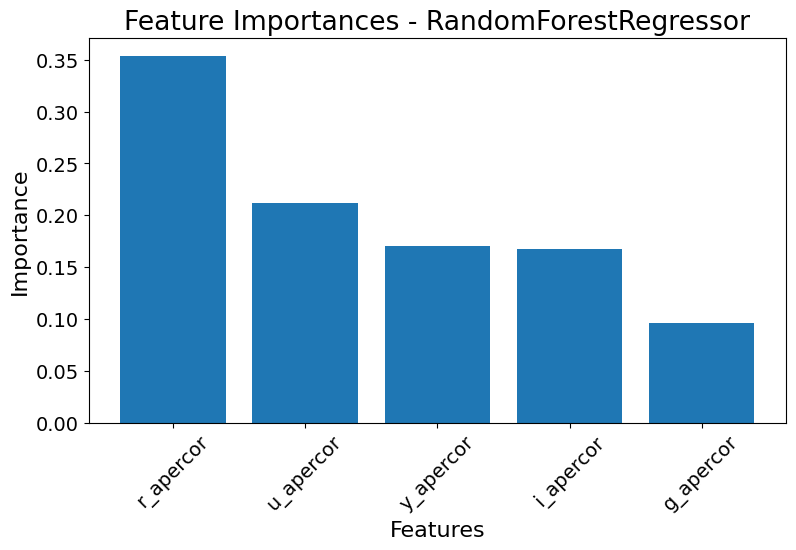

CV score RF: 0.7343471372103635


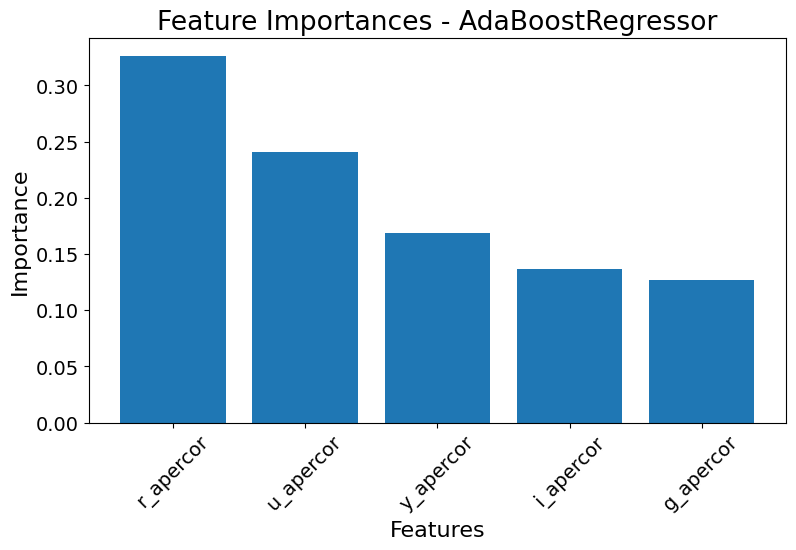

CV score Ada: 0.7054256990468893


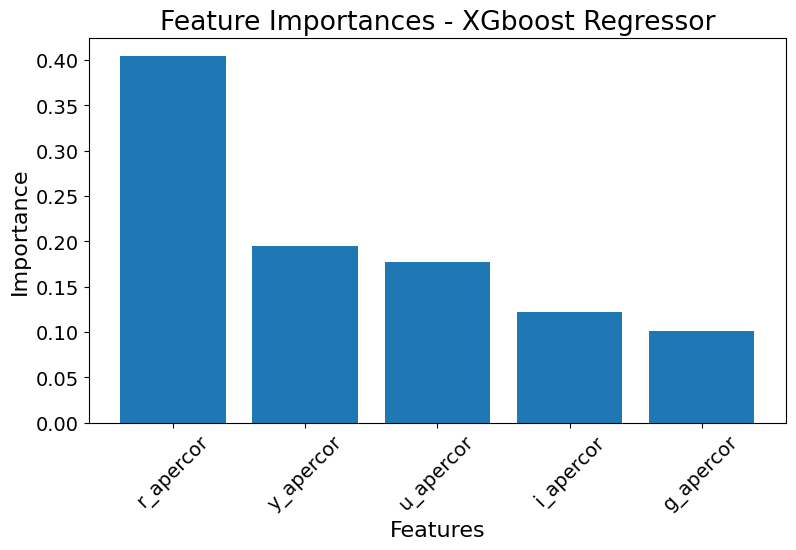

CV score XG: 0.71884815049579


In [17]:
from sklearn.model_selection import cross_val_score

sel_target = pd.read_csv('sel_target.csv')
sel_target = sel_target.to_numpy().T[0] #fix error.

## 1
best_params = {'max_depth': None, 'n_estimators': 100}

model = RandomForestRegressor(**best_params)
model.fit(sel_features, sel_target)

feature_importances = model.feature_importances_
sort_index = np.argsort(feature_importances)[::-1]
feature_importances = feature_importances[sort_index]
feature_names = sel_features.columns[sort_index]


plt.figure(figsize=(9, 5))
plt.bar(feature_names, feature_importances)
plt.title('Feature Importances - RandomForestRegressor')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.show()

print('CV score RF: {}'.format(cross_val_score(model, sel_features, sel_target, cv=3).mean()))


## 2
best_params= {'learning_rate': 0.3, 'loss': 'linear', 'n_estimators': 50}

model = AdaBoostRegressor(estimator = DecisionTreeRegressor(max_depth = None), **best_params)
model.fit(sel_features, sel_target)

feature_importances = model.feature_importances_
sort_index = np.argsort(feature_importances)[::-1]
feature_importances = feature_importances[sort_index]
feature_names = sel_features.columns[sort_index]


plt.figure(figsize=(9, 5))
plt.bar(feature_names, feature_importances)
plt.title('Feature Importances - AdaBoostRegressor')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.show()

print('CV score Ada: {}'.format(cross_val_score(model, sel_features, sel_target, cv=3).mean()))

## 3
best_params= {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'objective': 'reg:squaredlogerror'}

model = xgboost.XGBRegressor(**best_params)
model.fit(sel_features, sel_target)

feature_importances = model.feature_importances_
sort_index = np.argsort(feature_importances)[::-1]
feature_importances = feature_importances[sort_index]
feature_names = sel_features.columns[sort_index]

plt.figure(figsize=(9, 5))
plt.bar(feature_names, feature_importances)
plt.title('Feature Importances - XGboost Regressor')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.show()

print('CV score XG: {}'.format(cross_val_score(model, sel_features, sel_target, cv=3).mean()))